<a href="https://colab.research.google.com/github/JJay1010/K-software_-/blob/main/SuminLee/Project4/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.프로젝트 개요
**Project 4: 두피 데이터 분석 시스템**
1. 두피측정 빅데이터를 이용한 자동진단 및 제품 추천 시스템
2. 필요 기술 스택: Python, Python Library(Pillow, Opencv), Deep Learning + Docker file

3. 프로세스
- json 데이터를 분석하여 증상별 상관관계를 찾는다.
- 분석한 결과를 토대로 증상에 맞게 제품을 추천한다.
- 두피 이미지로 강도를 예측한다.
- 해결할 문제: json 데이터 분석과 이미지 예측 결과를 어떻게 엮어서 제품을 추천할 것인가?

# 2.일자별 진행 상황
1월 16일 작업 계획

1) 도커 공부: 이미지와 컨테이너의 개념
- image: container의 기본 레시피. 도커 파일을 빌드해서 만들 수 있다.
- container: image로 만든 인스턴스


2) 데이터 이해하기
- 데이터셋 다운로드 및 확인
- 무엇을 할 것인지 생각하기 (모델링 방향) => *일단 미세각질 이미지만 단계별 분류*

1월 17일

1) 무엇을 할 것인지 생각하기
- json 데이터를 분석하여 증상별 상관관계를 찾는다.
- 분석한 결과가 맞는지 증명한다. (이론 등을 이용)
- 증상에 맞게 제품을 추천한다. 이를 위해선 제품에 대한 조사가 필요하다.

2) 미세각질, 탈모 데이터 분석
- 시각화
- 상관관계 분석


1월 18일

1) 상관관계 분석 예제들 찾기

2) docker 실습

3) 이미지 데이터로 모델링 및 학습 진행
- 정확도가 너무 낮다 => 튜닝 필요
- fine tuning (미완)
- 하이퍼 파라미터 튜닝 (진행 중) => 서치 알고리즘 더 찾아보기

1월 19일

1) 이미지 정규화: 여러 범위로 적용해보기

2) 모델 레이어 추가하기

3) 제너레이터로 이미지 데이터 증강하기

4) 하이퍼 파라미터 튜닝: 서치 알고리즘 더 찾아보기

# 3.1 데이터 분석 (미세각질)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
#라이브러리
from PIL import Image
import os
import json
import pandas as pd
import numpy as np
from pandas import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import imageio #이미지 불러오기
import skimage # Numpy배열로 이미지 객체를 다룬다.
import skimage.io
import skimage.transform

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import tensorflow as tf

In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_미세각질_0
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]미세각질_0.양호.zip'

In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_미세각질_1
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]미세각질_1.경증.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_1


In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_미세각질_2
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]미세각질_2.중등도.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_2


In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_미세각질_3
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]미세각질_3.중증.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_3


In [33]:
%cd /content/drive/MyDrive/Project4/Dataset/원천_미세각질
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[원천]미세각질_0.양호.zip'

/content/drive/MyDrive/Project4/Dataset/원천_미세각질


In [34]:
%cd /content/drive/MyDrive/Project4/Dataset/원천_미세각질
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[원천]미세각질_1.경증.zip'

/content/drive/MyDrive/Project4/Dataset/원천_미세각질


In [35]:
%cd /content/drive/MyDrive/Project4/Dataset/원천_미세각질
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[원천]미세각질_2.중등도.zip'

/content/drive/MyDrive/Project4/Dataset/원천_미세각질


In [36]:
%cd /content/drive/MyDrive/Project4/Dataset/원천_미세각질
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[원천]미세각질_3.중증.zip'

/content/drive/MyDrive/Project4/Dataset/원천_미세각질


In [3]:
li_1 = ["라벨_미세각질_0", "라벨_미세각질_1", "라벨_미세각질_2", "라벨_미세각질_3"]

In [4]:
def openJson(li):
  df = pd.DataFrame({'image_id':[], 'image_file_name':[], 'value_1':[],'value_2':[],'value_3':[],'value_4':[], 'value_5':[],'value_6':[]})

  for folder in li:

    path_jsons = "/content/drive/MyDrive/Project4/Dataset/"+folder+"/"
    print(path_jsons)

    json_list = (os.listdir(path_jsons)) #json 파일명 다 담기
    print(len(json_list))

    for i in range(0, len(json_list)):
      example_file = open(path_jsons+json_list[i])
      json_file = json.load(example_file)
      df2 = pd.DataFrame.from_dict(json_file, orient="index")
      df2 = df2.transpose()
      df = pd.concat([df,df2], ignore_index = True)

  return df

In [5]:
df_1 = openJson(li_1)

/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_0/
152
/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_1/
1267
/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_2/
1568
/content/drive/MyDrive/Project4/Dataset/라벨_미세각질_3/
652


In [6]:
df_1

,image_id,image_file_name,value_1,value_2,value_3,value_4,value_5,value_6
0,7701_A1LCAIHDH000085_1610172715604_5,7701_A1LCAIHDH000085_1610172715604_5_RH.jpg,0,0,0,0,0,0
1,7978_A2LEBJJDE00071B_1606728948115_4,7978_A2LEBJJDE00071B_1606728948115_4_LH.jpg,0,0,0,0,0,0
2,9414_A2LEBJJDE00033L_1605521474634_2,9414_A2LEBJJDE00033L_1605521474634_2_TH.jpg,0,0,0,0,0,0
3,7670_A1LCAIHDH000126_1609648809001_6,7670_A1LCAIHDH000126_1609648809001_6_BH.jpg,0,0,0,0,0,0
4,8262_A2LEBJJDE00047M_1602749232911_3,8262_A2LEBJJDE00047M_1602749232911_3_TH.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3634,1069_A2LEBJJDE00094D_1607579389669_6,1069_A2LEBJJDE00094D_1607579389669_6_BH.jpg,3,0,0,0,3,0
3635,8146_A2LEBJJDE00148A_1607650916866_6,8146_A2LEBJJDE00148A_1607650916866_6_BH.jpg,3,0,0,0,3,0
3636,4970_A1LCAIHDH00010K_1608001420956_2,4970_A1LCAIHDH00010K_1608001420956_2_TH.jpg,3,0,0,0,0,0
3637,2278_A2LEBJJDE00181Z_1606653240159_2,2278_A2LEBJJDE00181Z_1606653240159_2_TH.jpg,3,0,1,0,0,0


***value_1***: 미세각질(0,1,2,3 중 1개 값)

***value_2***: 피지과다(0,1,2,3 중 1개 값)

***value_3***: 모낭사이홍반(0,1,2,3 중 1개 값)

***value_4***: 모낭홍반/농포(0,1,2,3 중 1개 값)

***value_5***: 비듬(0,1,2,3 중 1개 값)

***value_6***: 탈모(0,1,2,3 중 1개 값)

In [7]:
#csv 저장
df_1.to_csv('/content/drive/MyDrive/Project4/Dataset/df_1.csv',index=False)

In [3]:
df_1 = pd.read_csv('/content/drive/MyDrive/Project4/Dataset/df_1.csv')

## 3.1.1 시각화

In [7]:
# 그래프 x축 정렬을 위해 int 타입으로 변환
df_1 = df_1.astype({'value_1':'int','value_2':'int', 'value_3':'int', 'value_4':'int', 'value_5':'int', 'value_6':'int'})

In [8]:
df_1.dtypes

image_id           object
image_file_name    object
value_1             int64
value_2             int64
value_3             int64
value_4             int64
value_5             int64
value_6             int64
dtype: object

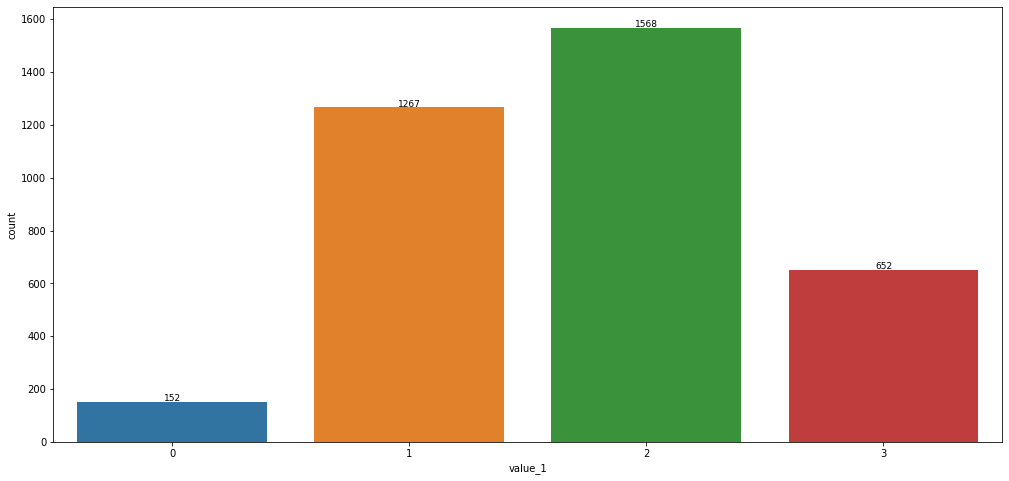

In [9]:
#미세각질 데이터 분포
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

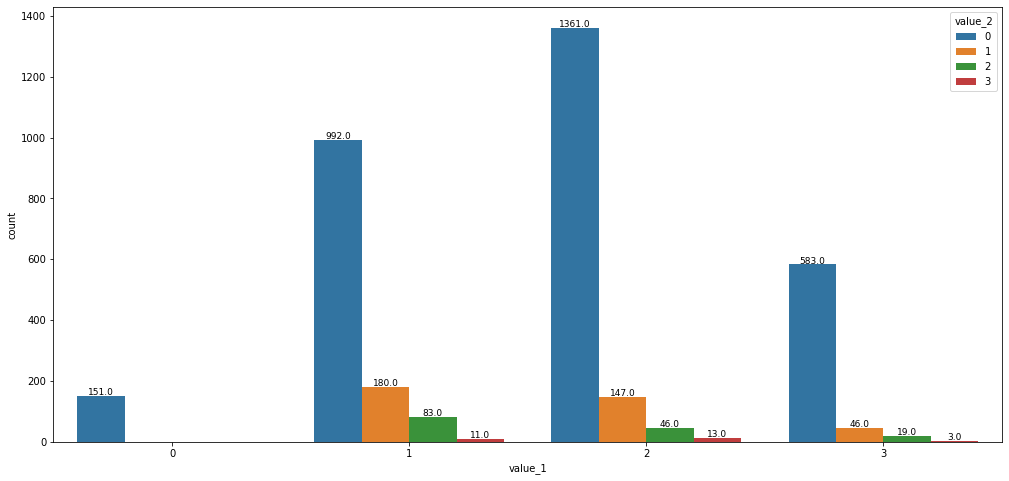

In [10]:
# 피지과다
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1.sort_values(by = 'value_2'), hue='value_2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

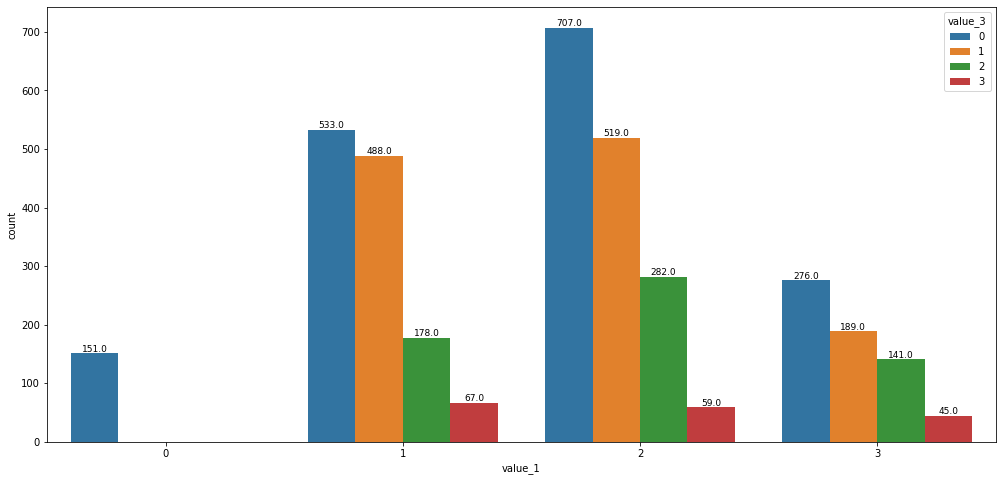

In [11]:
# 모낭사이홍반
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1.sort_values(by = 'value_3'), hue='value_3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

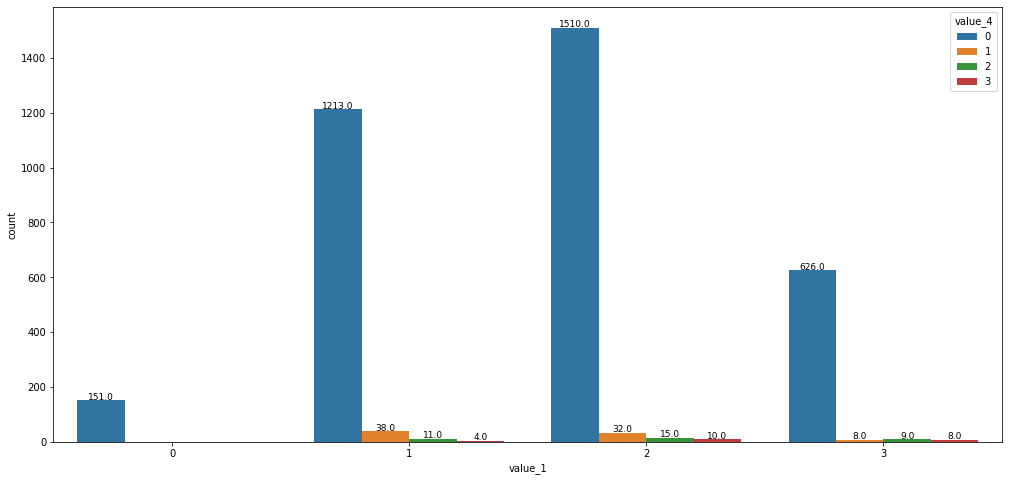

In [12]:
# 모낭홍반/농포
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1.sort_values(by = 'value_4'), hue='value_4')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

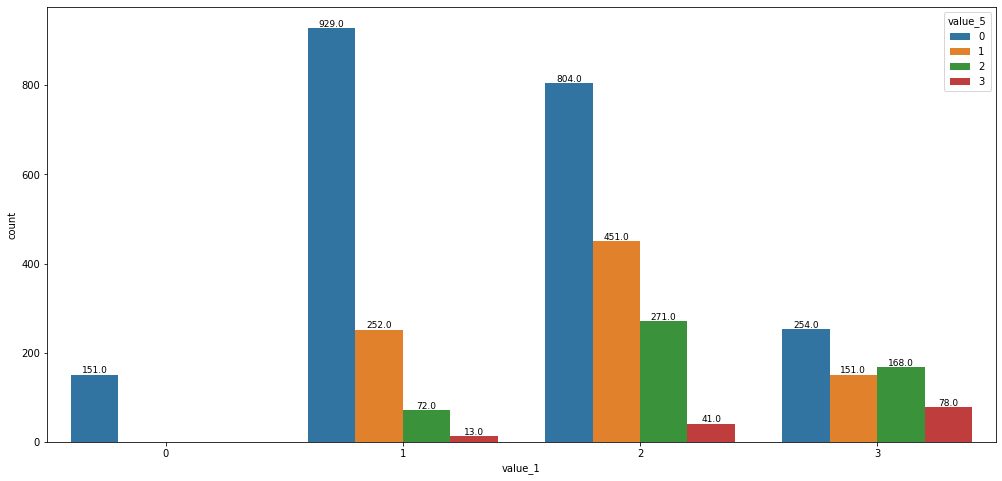

In [13]:
# 비듬
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1.sort_values(by = 'value_5'), hue='value_5')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

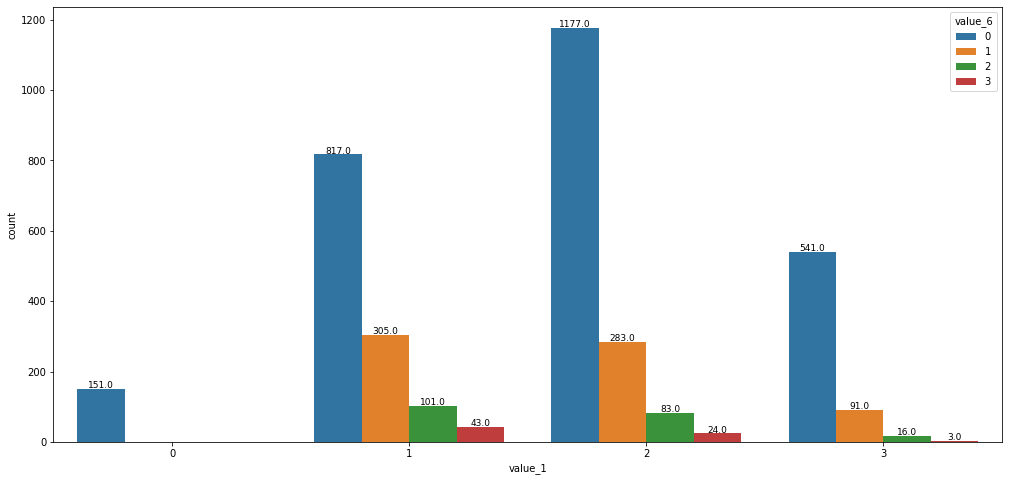

In [14]:
# 탈모
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_1', data=df_1.sort_values(by = 'value_6'), hue='value_6')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

count plot을 확인해본 결과,

- value 2, 4 (피지과다, 모낭홍반/농포)는 미세각질 강도가 증가하여도 눈에 띄게 강도 0 값이 많은 것을 확인하였다.
- ***가설 1: 미세각질과 피지과다/모낭홍반/농포는 동반되는 경우가 드물다.***

- value 3 (모낭사이홍반)은 미세각질 강도가 증가함에 따라 강도 1, 2, 3을 합한 값이 0보다 확연히 많다. 증상이 있는 경우가 많다.
- ***가설 2: 미세각질, 모낭사이홍반 증상은 함께 동반되는 경우가 많다.***



=> 다른 데이터도 이러한 방법으로 확인할 수 있다.

=> 제품을 추천할 때 유용할 것이다.

***미세각질***
- 두피표면의 천연보습인자(NMF) 부족과 피지선 기능이 저하되어 조기 박리증 증상을 보인다.
- 잔 각질이 관찰되며 모공 주변으로 나이테 모양의 각질층을 형성한다.
- 유수분의 부족으로 당김현상이나 가려움증을 호소한다.

***피지과다***
- 피지분비 과다로 두피 표면이 번들거리고 두피색은 탁하다.
- 심한 경우 피지산화 및 세균으로 인한 악취, 떡비듬, 지루성염증을 동반하기도 한다.

***모낭홍반/농포***
- 두피가 붉은 색을 띠며 표면에 홍반이 확인되는 경우가 있다.
- 세균감염으로 인한 염증이 있다.

***모낭사이홍반***
- 두피에 모세혈관 확장으로 인하여 홍반이나 출혈이 보인다.
- 태양열이나 에어컨바람과 같은 약한 자극에도 두피가 쉽게 붉어지고 통증이 있을 수 있다.


**미세각질 증상의 고객에게 제품을 추천한다면?**
- 건성 두피용 (유수분 부족 해결)
- 두피 염증은 크게 고려하지 않아도 된다.
- 약한 자극에도 통증이 있기 때문에 민감성 제품 추천





## 3.1.2 상관관계 분석
***스피어만 상관 계수***
- 스피어만 상관 계수는 두 데이터의 실제 값 대신 두 값의 **순위**를 사용해 상관 계수를 계산하는 방식이다.
- 피어슨 상관 계수와 달리 **비선형 관계의 연관성을 파악할 수 있다**는 장점이 있다.
- 또한, 연속형 데이터에 적합한 피어슨 상관 계수와 달리 **이산형 데이터, 순서형 데이터에 적용이 가능하다.**

***=> 각 value의 값들이 이산형이므로 스피어만 상관 계수 사용***



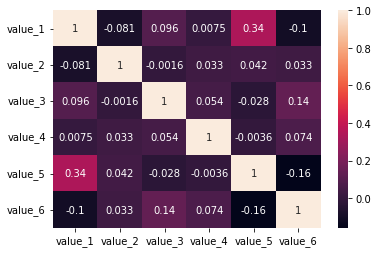

In [13]:
cols = df_1.columns[[2,3,4,5,6,7]]
sns.heatmap(df_1[cols].corr(method = 'spearman'), annot=True)
plt.show()

# 3.2 데이터 분석 (탈모)

In [16]:
li_6 = ["라벨_탈모_0", "라벨_탈모_1", "라벨_탈모_2", "라벨_탈모_3"]

In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_탈모_0
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]탈모_0.양호.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_탈모_0


In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_탈모_1
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]탈모_1.경증.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_탈모_1


In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_탈모_2
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]탈모_2.중등도.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_탈모_2


In [ ]:
%cd /content/drive/MyDrive/Project4/Dataset/라벨_탈모_3
!unzip -qq '/content/drive/MyDrive/Project4/Dataset/[라벨]탈모_3.중증.zip'

/content/drive/MyDrive/Project4/Dataset/라벨_탈모_3


In [17]:
df_6 = openJson(li_6)

/content/drive/MyDrive/Project4/Dataset/라벨_탈모_0/
152
/content/drive/MyDrive/Project4/Dataset/라벨_탈모_1/
3813
/content/drive/MyDrive/Project4/Dataset/라벨_탈모_2/
1084
/content/drive/MyDrive/Project4/Dataset/라벨_탈모_3/
239


In [18]:
df_6

,image_id,image_file_name,value_1,value_2,value_3,value_4,value_5,value_6
0,8896_A2LEBJJDE001807_1606455960324_3,8896_A2LEBJJDE001807_1606455960324_3_TH.jpg,0,0,0,0,0,0
1,8781_A2LEBJJDE000906_539482042_3,8781_A2LEBJJDE000906_539482042_3_TH.jpg,0,0,0,0,0,0
2,8814_A2LEBJJDE00118S_1603072051977_4,8814_A2LEBJJDE00118S_1603072051977_4_LH.jpg,0,0,0,0,0,0
3,9414_A2LEBJJDE00033L_1605521474634_6,9414_A2LEBJJDE00033L_1605521474634_6_BH.jpg,0,0,0,0,0,0
4,7297_A2LEBJJDE00151I_1606701309614_4,7297_A2LEBJJDE00151I_1606701309614_4_LH.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5279,1981_A2LEBJJDE001493_1606634009469_5,1981_A2LEBJJDE001493_1606634009469_5_RH.jpg,2,0,2,0,0,3
5280,0715_A2LEBJJDE00175D_1608812596197_3,0715_A2LEBJJDE00175D_1608812596197_3_TH.jpg,0,2,1,0,0,3
5281,4370_A1LCAIHDH00005Q_1607837222616_5,4370_A1LCAIHDH00005Q_1607837222616_5_RH.jpg,1,0,0,0,0,3
5282,4970_A1LCAIHDH00010K_1608355030996_5,4970_A1LCAIHDH00010K_1608355030996_5_RH.jpg,0,1,0,0,0,3


## 3.2.1 시각화

In [19]:
# 그래프 x축 정렬을 위해 int 타입으로 변환
df_6 = df_6.astype({'value_1':'int','value_2':'int', 'value_3':'int', 'value_4':'int', 'value_5':'int', 'value_6':'int'})

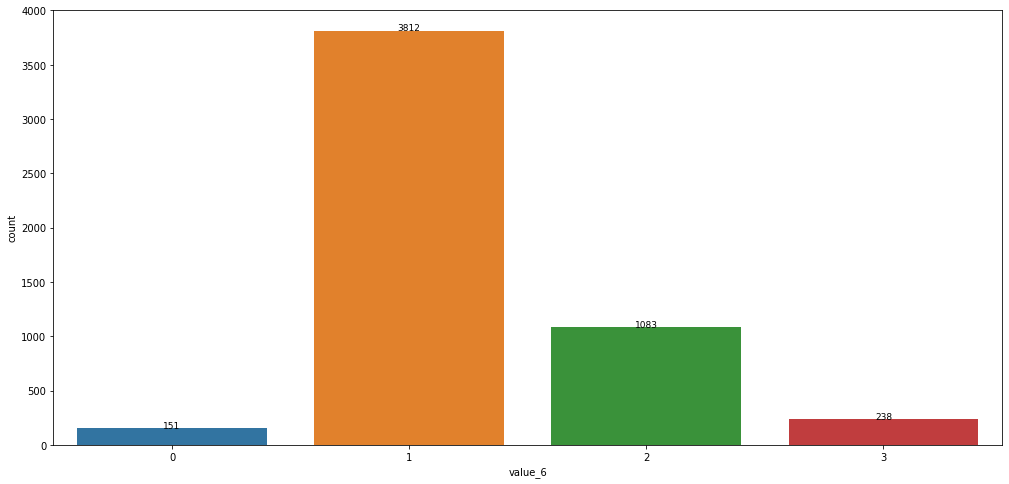

In [20]:
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

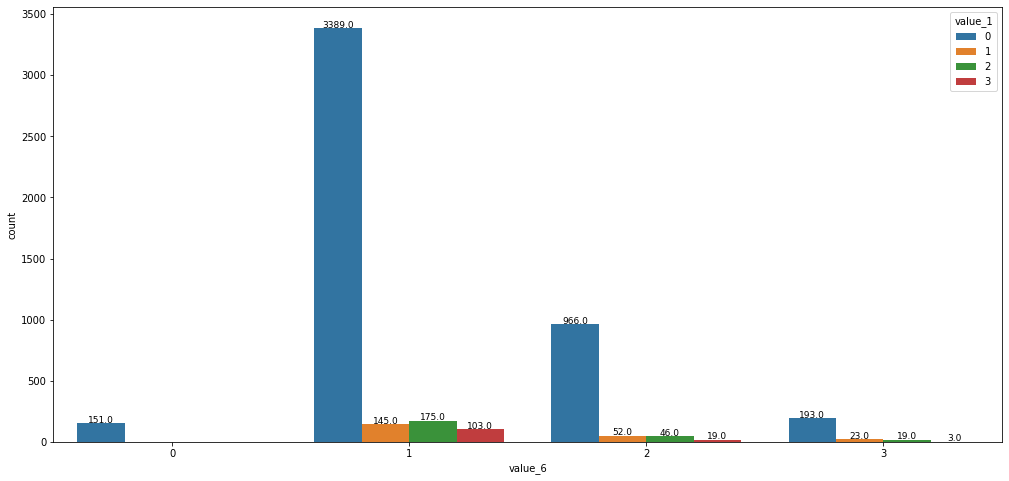

In [21]:
# 미세각질
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6.sort_values(by = 'value_1'), hue='value_1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

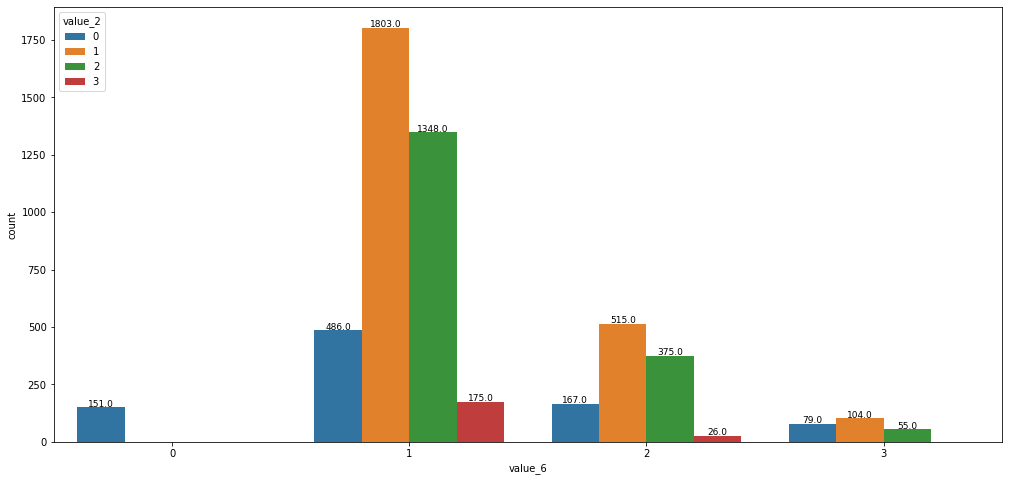

In [22]:
# 피지과다
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6.sort_values(by = 'value_2'), hue='value_2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

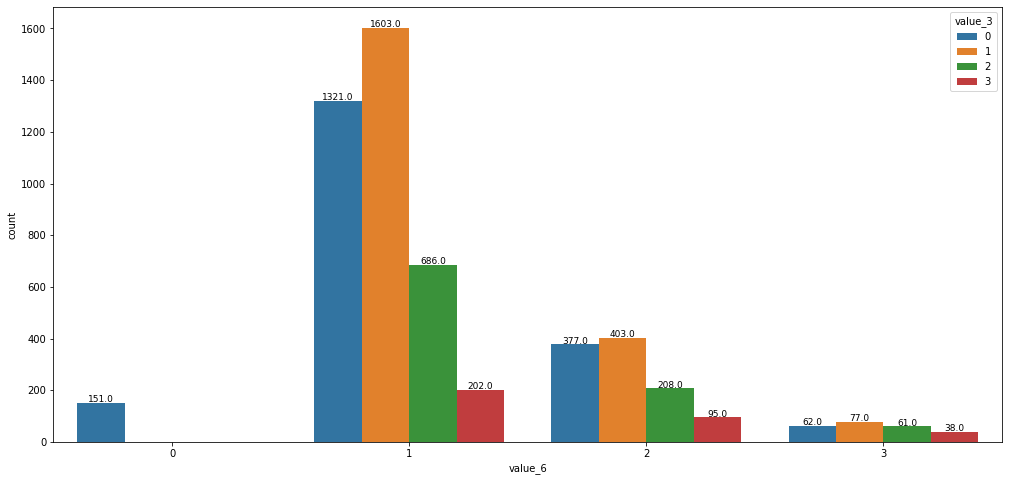

In [23]:
# 모낭사이홍반
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6.sort_values(by = 'value_3'), hue='value_3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

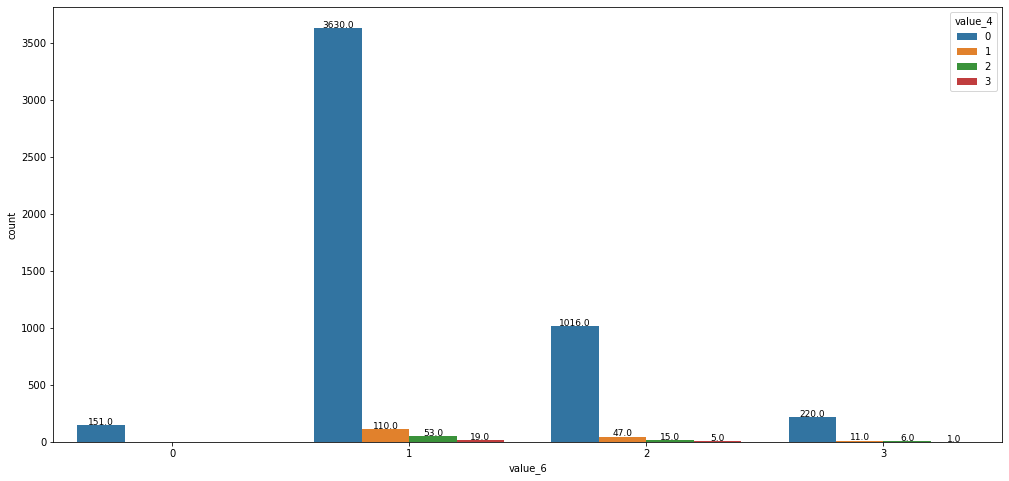

In [24]:
# 모낭홍반/농포
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6.sort_values(by = 'value_4'), hue='value_4')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

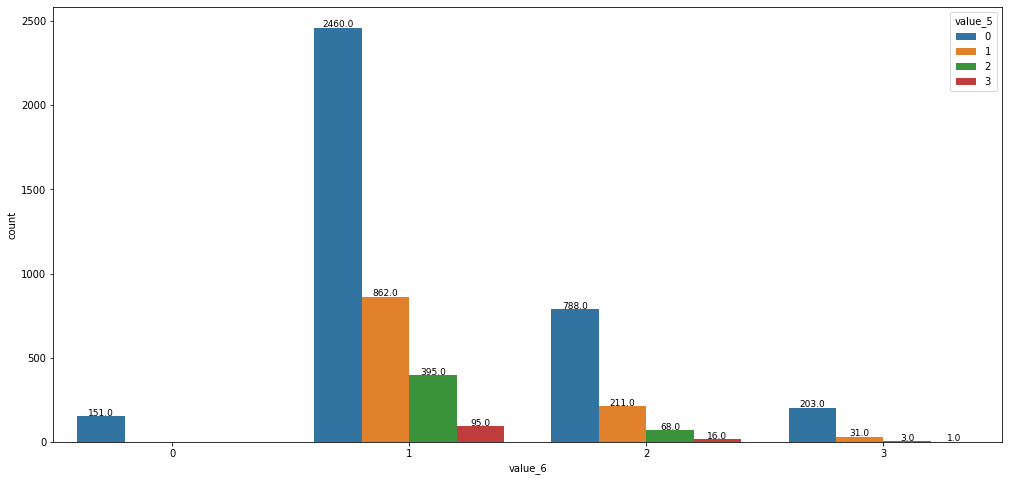

In [25]:
# 비듬
plt.figure(figsize=(17,8))
ax = sns.countplot(x='value_6', data=df_6.sort_values(by = 'value_5'), hue='value_5')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

count polt을 확인해본 결과,

- value 1, 4 (미세각질, 모낭홍반/농포)는 탈모 강도가 증가하여도 눈에 띄게 강도 0 값이 많은 것을 확인하였다.
- ***가설 1: 탈모와 미세각질/모낭홍반/농포는 동반되는 경우가 드물다.***
- value 2, 3 (피지과다, 모낭사이홍반)은 탈모 강도가 증가함에 따라 증상이 있는 경우가 확연히 많았다.
- ***가설 2: 탈모, 피지과다, 모낭사이홍반 증상은 함께 동반되는 경우가 많다.***


***탈모***
- 모발이 있어야 할 부위에 없거나 연모화가 빠르게 진행되는 것이 특징이다.
- 유전, 호르몬, 환경 등 복합적인 영향이 원인이다.
- 환경적인 탈모의 경우 가려움을 동반하기도 하고 비듬과 피지분비량이 증가한다고 한다.
- 유전적인 탈모의 경우 특별한 이상이 관찰되지 않으며, 밀도가 급격히 낮아지는 것이 특징이다.

***미세각질***
- 두피표면의 천연보습인자(NMF) 부족과 피지선 기능이 저하되어 조기 박리증 증상을 보인다.
- 잔 각질이 관찰되며 모공 주변으로 나이테 모양의 각질층을 형성한다.
- 유수분의 부족으로 당김현상이나 가려움증을 호소한다.

***모낭홍반/농포***
- 두피가 붉은 색을 띠며 표면에 홍반이 확인되는 경우가 있다.
- 세균감염으로 인한 염증이 있다.

***피지과다***
- 피지분비 과다로 두피 표면이 번들거리고 두피색은 탁하다.
- 모공에 물이 고여있는 것처럼 관찰되며 모발밀도가 낮다.
- 심한 경우 피지산화 및 세균으로 인한 악취, 떡비듬, 지루성염증을 동반하기도 한다.

***모낭사이홍반***
- 두피에 모세혈관 확장으로 인하여 홍반이나 출혈이 보인다.
- 태양열이나 에어컨바람과 같은 약한 자극에도 두피가 쉽게 붉어지고 통증이 있을 수 있다.

**탈모 증상의 고객에게 제품을 추천한다면?**
- 지성 두피용 (유수분 부족 해결)
- 약한 자극에도 통증이 있기 때문에 민감성 제품 추천
- 두피 염증은 크게 고려하지 않아도 된다.



## 3.2.2 상관관계 분석

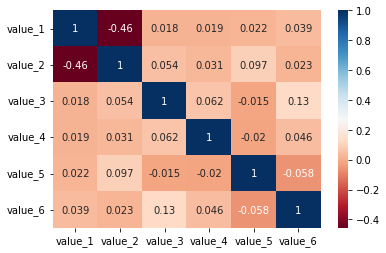

In [26]:
cols = df_6.columns[[2,3,4,5,6,7]]
sns.heatmap(df_6[cols].corr(method = 'spearman'), annot=True, cmap="RdBu")
plt.show()

# 4.이미지 처리

# 4.1 train/test set 준비

In [29]:
train_df, test_df = train_test_split(df_1, test_size = 0.2, random_state=1, stratify=df_1['value_1'])

In [30]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))

Train set rows: 2911
Test  set rows: 728


In [31]:
path_images = "/content/drive/MyDrive/Project4/Dataset/원천_미세각질/"

In [76]:
def read_image(file_name):
  image = skimage.io.imread(path_images + file_name) / 255
  image = skimage.transform.resize(image, (224, 224), mode='reflect')
  #print(file_name)
  return image[:,:,:3]

In [77]:
def categories_encoder(dataset, var):
  X=np.stack(dataset['image_file_name'].apply(read_image))
  y = pd.get_dummies(dataset[var], drop_first=False)
  return X,y

In [78]:
X_train, y_train = categories_encoder(train_df, 'value_1')

In [79]:
X_test, y_test = categories_encoder(test_df, 'value_1')

In [16]:
#np 배열 저장
np.save('/content/drive/MyDrive/Project4/Dataset/X_train_1', X_train)
np.save('/content/drive/MyDrive/Project4/Dataset/X_test_1', X_test)

In [80]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2911, 224, 224, 3)
(2911, 4)
(728, 224, 224, 3)
(728, 4)


In [81]:
#이미지 augmentation
from skimage import transform
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise
from skimage.filters import gaussian
def read_image_2(file_name):
  image = skimage.io.imread(path_images + file_name) / 255
  image = skimage.transform.resize(image, (224, 224), mode='reflect')
  #noised = random_noise(image, var=0.1**2)
  image2 = rotate(image, angle=45)
  tf = AffineTransform(shear=-0.5)
  image2 = transform.warp(image2, tf, order=1, preserve_range=True)

  #print(file_name)
  return image2[:,:,:3]

In [82]:
def categories_encoder_2(dataset, var):
  X=np.stack(dataset['image_file_name'].apply(read_image_2))
  y = pd.get_dummies(dataset[var], drop_first=False)
  return X,y

In [83]:
X_train_a, y_train_a = categories_encoder_2(train_df, 'value_1')

In [85]:
print(X_train_a.shape)
print(y_train_a.shape)

(2911, 224, 224, 3)
(2911, 4)


In [90]:
#최종 학습 데이터셋
X_train_final = np.concatenate((X_train, X_train_a), axis = 0)
y_train_final = pd.concat([y_train, y_train_a], ignore_index=True)

In [84]:
np.save('/content/drive/MyDrive/Project4/Dataset/X_train', X_train)

In [86]:
np.save('/content/drive/MyDrive/Project4/Dataset/X_train_a', X_train_a)

In [87]:
y_train.to_csv('/content/drive/MyDrive/Project4/Dataset/y_train.csv')
y_train_a.to_csv('/content/drive/MyDrive/Project4/Dataset/y_train_a.csv')

In [88]:
np.save('/content/drive/MyDrive/Project4/Dataset/X_test', X_test)
y_test.to_csv('/content/drive/MyDrive/Project4/Dataset/y_test.csv')

In [16]:
#저장된 배열로 쓸 때
X_train = np.load('/content/drive/MyDrive/Project4/Dataset/X_train.npy')
y_train = pd.read_csv('/content/drive/MyDrive/Project4/Dataset/y_train.csv')

X_train_a = np.load('/content/drive/MyDrive/Project4/Dataset/X_train_a.npy')
y_train_a = pd.read_csv('/content/drive/MyDrive/Project4/Dataset/y_train_a.csv')

X_test = np.load('/content/drive/MyDrive/Project4/Dataset/X_test.npy')
y_test = pd.read_csv('/content/drive/MyDrive/Project4/Dataset/y_test.csv')

In [92]:
print(X_train_final.shape)
print(X_test.shape)
print(y_train_final.shape)
print(y_test.shape)

(5822, 224, 224, 3)
(728, 224, 224, 3)
(5822, 4)
(728, 4)


# 4.2 모델링 및 학습

In [46]:
#하이퍼 파라미터 생성
INPUT_SHAPE = (100, 100, 3) # 입력 데이터가 들어가는 포멧 설정
OUTPUT_SHAPE = 4 # 출력 데이터가 나오는 포멧 설정
BATCH_SIZE = 64 # 한 번에 처리할 데이터량 설정
EPOCHS = 70 # 신경망을 학습할 횟수
VERBOSE = 1 # 학습 진행 상황 출력 모드 설정 

In [67]:
#VGG net
from keras.layers import BatchNormalization, Dropout, Activation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
  Conv2D(64, 3, strides=1, padding='same', input_shape=INPUT_SHAPE),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(64, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  MaxPooling2D((2,2), strides=2),

  Conv2D(128, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(128, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  MaxPooling2D((2,2), strides=2),

  Conv2D(256, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(256, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(256, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  MaxPooling2D((2,2), strides=2),

  Conv2D(512, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(512, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  Conv2D(512, 3, strides=1, padding='same'),
  BatchNormalization(),
  Activation(activation='relu'),
  MaxPooling2D((2,2), strides=2),
  MaxPooling2D((2,2), strides=2),

  Flatten(),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(4, activation='softmax')
])


In [68]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy', 
    #categorical_crossentropy: 다중 분류 손실함수. 출력값이 원 핫 인코딩 된 결과로 나온다.
    #각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
    metrics=['accuracy']
)

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 batch_normalization_10 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 100, 100, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization_11 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 100, 100, 64)     

In [52]:
#추가 데이터 X
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_split=0.2,
)

Epoch 1/70
37/37 [==============================] - 3s 52ms/step - loss: 8.3803 - accuracy: 0.3587 - val_loss: 1.3144 - val_accuracy: 0.4322
Epoch 2/70
37/37 [==============================] - 2s 41ms/step - loss: 1.3351 - accuracy: 0.4175 - val_loss: 1.2079 - val_accuracy: 0.3448
Epoch 3/70
37/37 [==============================] - 2s 41ms/step - loss: 1.3027 - accuracy: 0.4171 - val_loss: 1.1884 - val_accuracy: 0.3448
Epoch 4/70
37/37 [==============================] - 2s 41ms/step - loss: 1.2402 - accuracy: 0.4137 - val_loss: 1.1755 - val_accuracy: 0.4322
Epoch 5/70
37/37 [==============================] - 2s 41ms/step - loss: 1.2425 - accuracy: 0.4321 - val_loss: 1.1739 - val_accuracy: 0.4322
Epoch 6/70
37/37 [==============================] - 2s 41ms/step - loss: 1.2215 - accuracy: 0.4115 - val_loss: 1.1755 - val_accuracy: 0.4322
Epoch 7/70
37/37 [==============================] - 2s 42ms/step - loss: 1.2216 - accuracy: 0.4171 - val_loss: 1.1721 - val_accuracy: 0.4322
Epoch 8/70
37

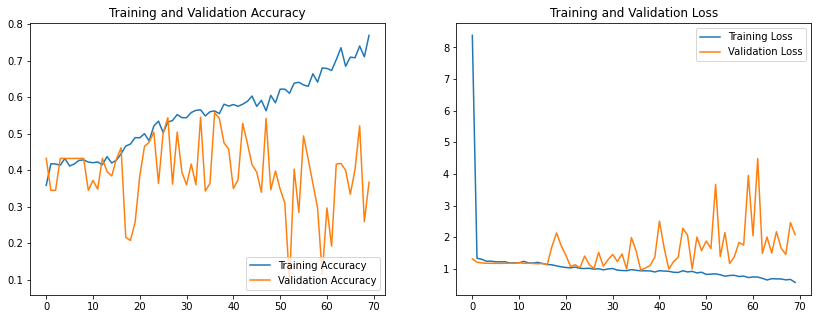

In [54]:
#결과 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [55]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 8ms/step - loss: 2.1679 - accuracy: 0.3379


[2.1678593158721924, 0.33791208267211914]

In [69]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_split=0.2
)

Epoch 1/70
73/73 [==============================] - 5s 47ms/step - loss: 5.0161 - accuracy: 0.3861 - val_loss: 1.2014 - val_accuracy: 0.4180
Epoch 2/70
73/73 [==============================] - 3s 41ms/step - loss: 1.3610 - accuracy: 0.3983 - val_loss: 1.2270 - val_accuracy: 0.4180
Epoch 3/70
73/73 [==============================] - 3s 41ms/step - loss: 1.2278 - accuracy: 0.4071 - val_loss: 1.2058 - val_accuracy: 0.4180
Epoch 4/70
73/73 [==============================] - 3s 41ms/step - loss: 1.2038 - accuracy: 0.4026 - val_loss: 1.2124 - val_accuracy: 0.4180
Epoch 5/70
73/73 [==============================] - 3s 41ms/step - loss: 1.1795 - accuracy: 0.4144 - val_loss: 1.2164 - val_accuracy: 0.4180
Epoch 6/70
73/73 [==============================] - 3s 41ms/step - loss: 1.1532 - accuracy: 0.4297 - val_loss: 1.1705 - val_accuracy: 0.4180
Epoch 7/70
73/73 [==============================] - 3s 41ms/step - loss: 1.1248 - accuracy: 0.4642 - val_loss: 1.3499 - val_accuracy: 0.3459
Epoch 8/70
73

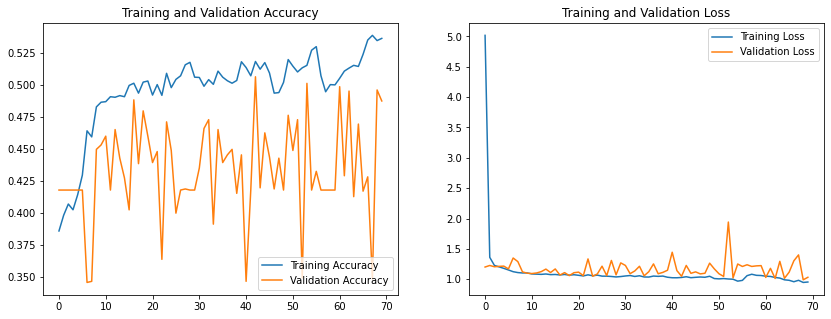

In [70]:
#결과 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [71]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 9ms/step - loss: 1.0575 - accuracy: 0.5261


[1.0574524402618408, 0.526098906993866]

In [63]:
#lr을 더 낮추기
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy', 
    #categorical_crossentropy: 다중 분류 손실함수. 출력값이 원 핫 인코딩 된 결과로 나온다.
    #각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
    metrics=['accuracy']
)

In [64]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_split=0.2
)

Epoch 1/70
73/73 [==============================] - 5s 47ms/step - loss: 2.1641 - accuracy: 0.3902 - val_loss: 1.2468 - val_accuracy: 0.3468
Epoch 2/70
73/73 [==============================] - 3s 41ms/step - loss: 1.2804 - accuracy: 0.4312 - val_loss: 1.7574 - val_accuracy: 0.3468
Epoch 3/70
73/73 [==============================] - 3s 42ms/step - loss: 1.1880 - accuracy: 0.4589 - val_loss: 2.0107 - val_accuracy: 0.3468
Epoch 4/70
73/73 [==============================] - 3s 41ms/step - loss: 1.1401 - accuracy: 0.4692 - val_loss: 2.3060 - val_accuracy: 0.3468
Epoch 5/70
73/73 [==============================] - 3s 41ms/step - loss: 1.0625 - accuracy: 0.4988 - val_loss: 2.6355 - val_accuracy: 0.3468
Epoch 6/70
73/73 [==============================] - 3s 41ms/step - loss: 1.0326 - accuracy: 0.5143 - val_loss: 2.0842 - val_accuracy: 0.3468
Epoch 7/70
73/73 [==============================] - 3s 42ms/step - loss: 1.0023 - accuracy: 0.5269 - val_loss: 1.7199 - val_accuracy: 0.3468
Epoch 8/70
73

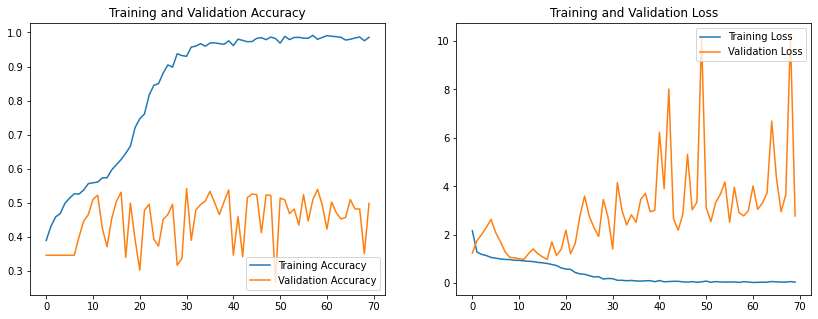

In [65]:
#결과 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [66]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 8ms/step - loss: 3.2064 - accuracy: 0.4904


[3.206367254257202, 0.49038460850715637]

In [72]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
 
model = MobileNet(weights='imagenet')


17225924/17225924 [==============================] - 0s 0us/step


In [73]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy', 
    #categorical_crossentropy: 다중 분류 손실함수. 출력값이 원 핫 인코딩 된 결과로 나온다.
    #각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
    metrics=['accuracy']
)

In [74]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [75]:
#추가 데이터 X
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_split=0.2,
)

Epoch 1/70


ValueError: ignored

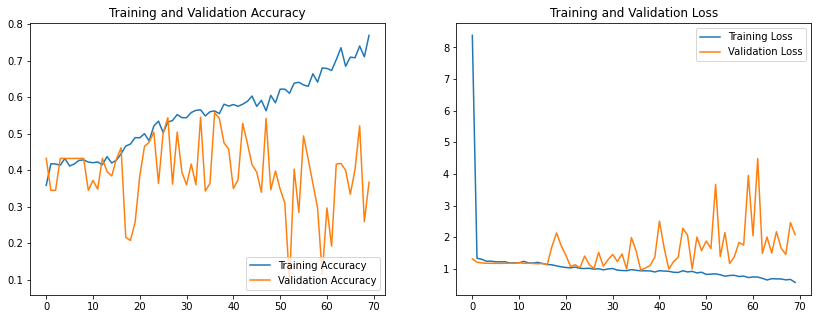

In [ ]:
#결과 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 8ms/step - loss: 2.1679 - accuracy: 0.3379


[2.1678593158721924, 0.33791208267211914]

# 4.3 하이퍼 파라미터 튜닝

In [41]:
from tensorflow.keras.regularizers import L1, L2
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def build_model_rscv(nodes, L1_values, L2_values, dropout_values):

  model = Sequential([
  Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
  MaxPooling2D(pool_size=(2, 2)), 

  Flatten(),

  Dense(nodes, activation='relu', kernel_regularizer=L2(L2_values)),
  Dropout(dropout_values),

  Dense(nodes, activation='relu', activity_regularizer=L1(L1_values)),
  Dropout(dropout_values),

  Dense(4, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 

    metrics=['accuracy']
  )

  return model

In [42]:
temp_rscv = KerasClassifier(build_fn=build_model_rscv, verbose=0)

<ipython-input-42-a580792a4654>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  temp_rscv = KerasClassifier(build_fn=build_model_rscv, verbose=0)


In [47]:
import random

nodes=[random.randint(64, 128) for n in range(5)]
L1_values=[random.uniform(0, 0.000001) for n in range(5)]
L2_values=[random.uniform(0, 0.000001) for n in range(5)]
dropout_values=[random.uniform(0, 1) for n in range(5)]
batch_sizes=[random.randint(32, 64) for n in range(5)]
epochs=[random.choice(range(30, 160, 10)) for n in range(5)]

In [48]:
params = dict(nodes=nodes,
              L1_values=L1_values,
              L2_values=L2_values,
              dropout_values=dropout_values,
              batch_size=batch_sizes,
              epochs=epochs
              )

In [49]:
model_best = RandomizedSearchCV(estimator=temp_rscv,
                                param_distributions=params,
                                n_iter=10,
                                cv=3,
                                scoring='accuracy',
                                verbose=1,
                                n_jobs=-1
                                )

In [50]:
history = model_best.fit(
    X_train, y_train,
    validation_split=0.2
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [51]:
rs = pd.DataFrame(model_best.cv_results_).sort_values(by='rank_test_score').head()
rs.T

,0,1,2,3,4
mean_fit_time,69.860762,99.552037,100.664553,76.114082,70.050294
std_fit_time,13.899386,1.574385,32.290038,14.605508,11.191937
mean_score_time,1.314526,0.754752,0.760037,0.966445,0.855877
std_score_time,0.814512,0.095335,0.287182,0.21938,0.308996
param_nodes,69,89,78,69,69
param_epochs,90,140,130,90,90
param_dropout_values,0.474649,0.435152,0.885669,0.885669,0.783383
param_batch_size,63,63,63,63,33
param_L2_values,0.0,0.000001,0.0,0.0,0.0
param_L1_values,0.000001,0.0,0.0,0.000001,0.0
